## Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Setup helper Functions

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    plt.figure(figsize=(20,20))
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()*100
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## Load Data

In [3]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("train.csv")
test    = pd.read_csv("test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

('Datasets:', 'full:', (1309, 12), 'titanic:', (891, 12))


## Exploration and summaries

In [4]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [5]:
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


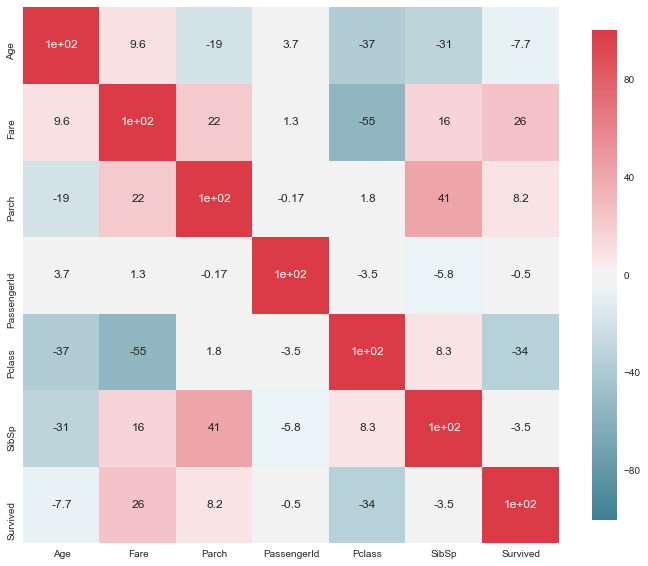

In [6]:
plot_correlation_map( titanic )

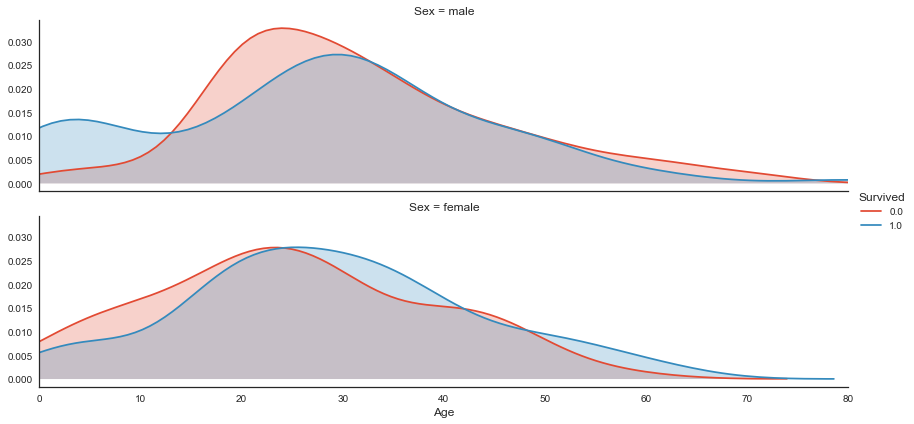

In [7]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

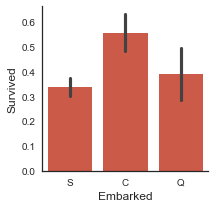

In [8]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

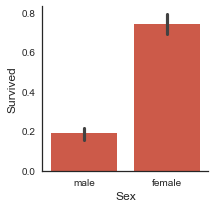

In [9]:
# Plot survival rate by Sex
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

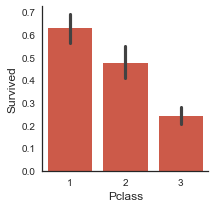

In [10]:
# Plot survival rate by Pclass
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

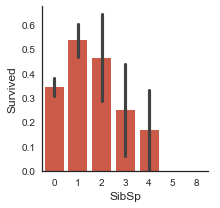

In [11]:
# Plot survival rate by SibSp
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

## Data Preparation

In [12]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [13]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [14]:
# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [15]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [16]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [17]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [18]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [20]:
# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin , ticket

full_X = pd.concat( [ imputed , embarked , cabin , sex ] , axis=1 )
full_X.head()

,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Sex
0,22.0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1,1
1,38.0,71.2833,1,0,0,0,0,1,0,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,0,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,0,0,1,0,0,1,0,0,0,0,0,0,0
4,35.0,8.0500,0,0,1,0,0,0,0,0,0,0,0,1,1


## Create datasets

In [21]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

((1309, 15), (623, 15), (268, 15), (623L,), (268L,), (418, 15))


## Feature Important

0.988764044944


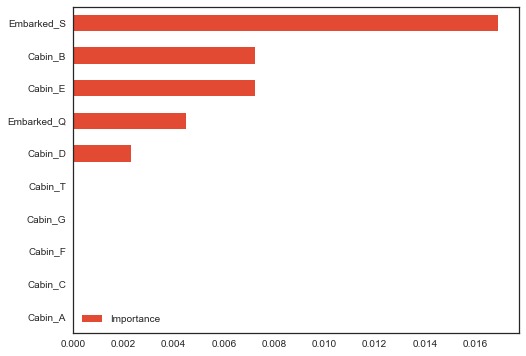

In [22]:
plot_variable_importance(train_X, train_y)

## List of Modeling

In [23]:
modelan = [RandomForestClassifier,SVC,GradientBoostingClassifier,KNeighborsClassifier,GaussianNB,LogisticRegression]
modelan

[sklearn.ensemble.forest.RandomForestClassifier,
 sklearn.svm.classes.SVC,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.linear_model.logistic.LogisticRegression]

## Details of Modeling

In [24]:
print(DecisionTreeClassifier())
print(LogisticRegression())
print(KNeighborsClassifier())
print(GaussianNB())
print(SVC())
print(LinearSVC())
print(RandomForestClassifier())
print(GradientBoostingClassifier())


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
GaussianNB(priors=None)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
LinearSVC(C

In [25]:
## collect all model in one list
all_model = [DecisionTreeClassifier,
            LogisticRegression,
            KNeighborsClassifier,
            GaussianNB,
            SVC,
            LinearSVC,
            RandomForestClassifier,
            GradientBoostingClassifier]
all_model

[sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.svm.classes.SVC,
 sklearn.svm.classes.LinearSVC,
 sklearn.ensemble.forest.RandomForestClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier]

In [26]:
## loop for all model

datatr = []
datasc = []
for i in all_model:
    model = i()
    model.fit(train_X,train_y)
    datatr.append(model.score( train_X , train_y ))
    datasc.append(model.score( valid_X , valid_y ))
    print(i, model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

(<class 'sklearn.tree.tree.DecisionTreeClassifier'>, 0.9887640449438202, 0.76865671641791045)
(<class 'sklearn.linear_model.logistic.LogisticRegression'>, 0.7929373996789727, 0.79477611940298509)
(<class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 0.7961476725521669, 0.72761194029850751)
(<class 'sklearn.naive_bayes.GaussianNB'>, 0.7367576243980738, 0.73880597014925375)
(<class 'sklearn.svm.classes.SVC'>, 0.8378812199036918, 0.70149253731343286)
(<class 'sklearn.svm.classes.LinearSVC'>, 0.6966292134831461, 0.71268656716417911)
(<class 'sklearn.ensemble.forest.RandomForestClassifier'>, 0.9695024077046549, 0.76119402985074625)
(<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 0.8956661316211878, 0.82835820895522383)


In [27]:
## compare model each other

data1 = pd.DataFrame()
data1['model'] = all_model
data1['score training'] = datatr
data1['score test'] = datasc
data1

,model,score training,score test
0,<class 'sklearn.tree.tree.DecisionTreeClassifi...,0.988764,0.768657
1,<class 'sklearn.linear_model.logistic.Logistic...,0.792937,0.794776
2,<class 'sklearn.neighbors.classification.KNeig...,0.796148,0.727612
3,<class 'sklearn.naive_bayes.GaussianNB'>,0.736758,0.738806
4,<class 'sklearn.svm.classes.SVC'>,0.837881,0.701493
5,<class 'sklearn.svm.classes.LinearSVC'>,0.696629,0.712687
6,<class 'sklearn.ensemble.forest.RandomForestCl...,0.969502,0.761194
7,<class 'sklearn.ensemble.gradient_boosting.Gra...,0.895666,0.828358


In [28]:
## maximum model on gradient boosting with 82.83%

data1[data1['score test']==data1['score test'].max()]

,model,score training,score test
7,<class 'sklearn.ensemble.gradient_boosting.Gra...,0.895666,0.828358


In [117]:
## find optimum estimators from Gradient Boosting Classifier


j=[]
dat1 = []
dat2 = []
dist = ['deviance','exponential']
jarak = np.arange(1,1000,1)
for i in jarak:
    model = GradientBoostingClassifier(n_estimators=i)
    model.fit(train_X,train_y)
    j.append(i)
    dat1.append(model.score( train_X , train_y ))
    dat2.append(model.score( valid_X , valid_y ))
#    print(i, model.score( train_X , train_y ) , model.score( valid_X , valid_y ) )

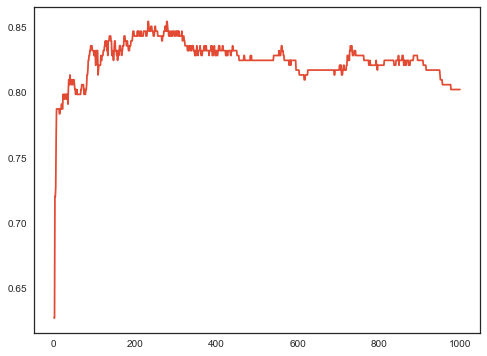

In [118]:
plt.plot(j,dat2)

In [119]:
## compare model each other

datamodel = pd.DataFrame()
datamodel['n estimators'] = j
datamodel['score training'] = dat1
datamodel['score test'] = dat2
datamodel[datamodel['score test']==datamodel['score test'].max()]

,n estimators,score training,score test
231,232,0.945425,0.854478
232,233,0.945425,0.854478
277,278,0.948636,0.854478
278,279,0.948636,0.854478


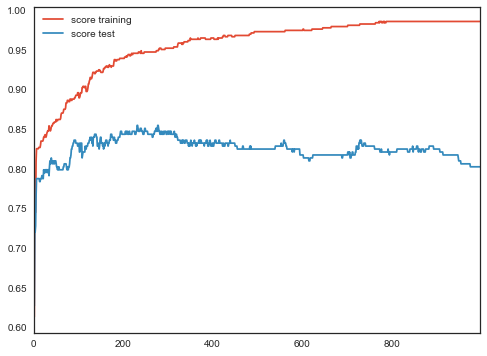

In [120]:
plt.figure(figsize=(20,15))
datamodel[['score training','score test']].plot()